# Homework 5 Attention

## Introduction

A reminder of what our initial model looked like:

<center><img src="https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/master/assets/seq2seq1.png" alt="mlp" align="middle"></center>

In this architecture, our context vector still needs to contain all of the information about the source sentence.

 The model implemented in this notebook avoids this compression by allowing the decoder to look at the entire source sentence (via its hidden states) at each decoding step! How does it do this? 
 
 It uses *attention*. 

Attention works by first, calculating an attention vector, $a$, that is the length of the source sentence. The attention vector has the property that each element is between 0 and 1, and the entire vector sums to 1. We then calculate a weighted sum of our source sentence hidden states, $H$, to get a weighted source vector, $w$. 

$$w = \sum_{i}a_ih_i$$

We calculate a new weighted source vector every time-step when decoding, using it as input to our decoder RNN as well as the linear layer to make a prediction. We'll explain how to do all of this during the tutorial.



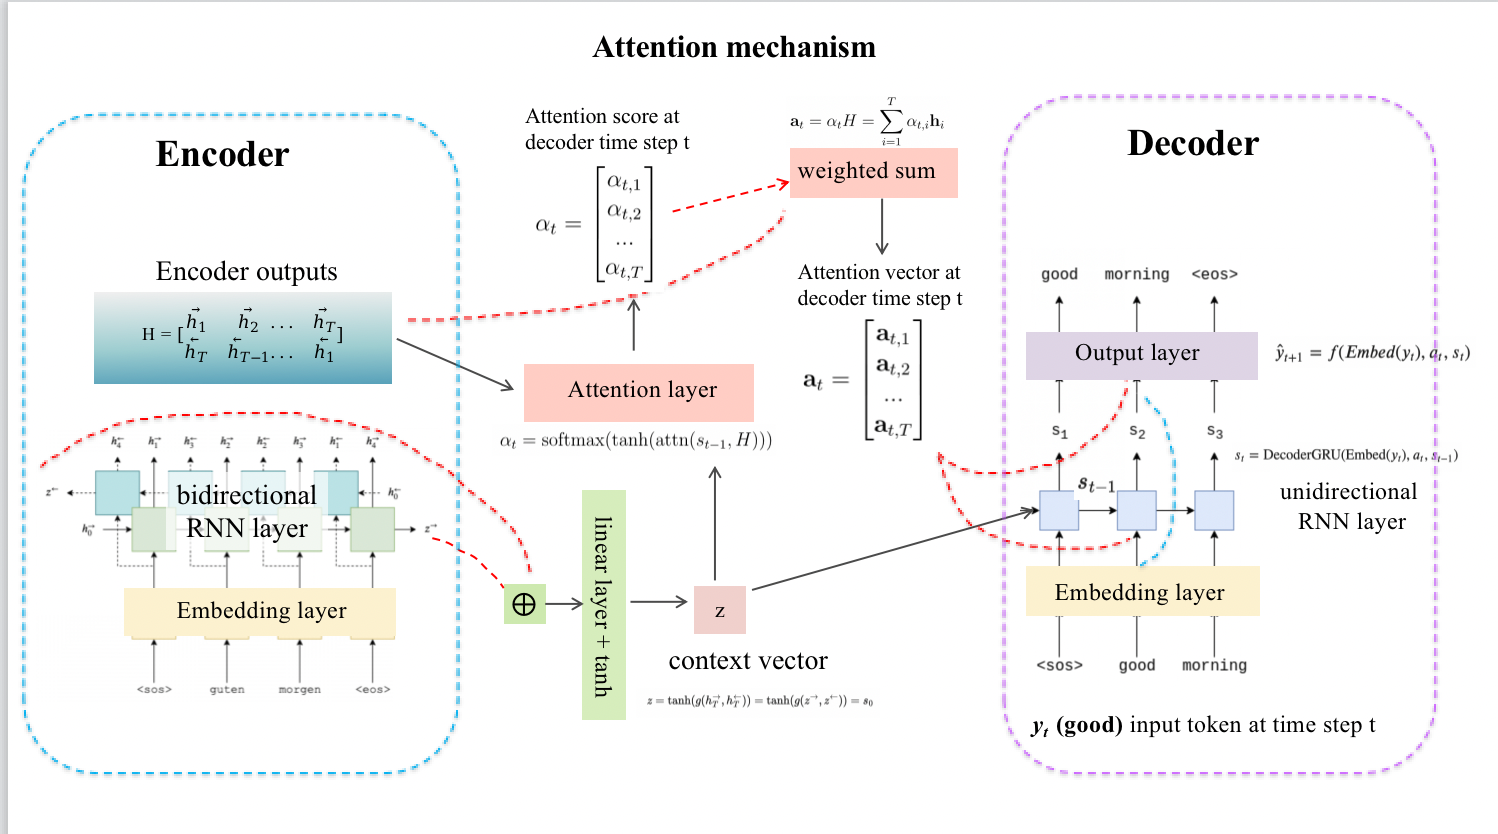

## Preparing Data

The preparation is the same as last time.

In [1]:
import locale

def getpreferredencoding(do_setlocale = True):
    return 'UTF-8'
locale.getpreferredencoding = getpreferredencoding
print(locale.getpreferredencoding())

! pip install -U spacy -q
! python -m spacy download en_core_web_sm -q
! python -m spacy download de_core_news_sm -q
! pip install torch==1.13.1 torchtext==0.14.1 torchdata==0.5.1 -q

UTF-8
2023-04-22 03:53:53.048029: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-22 03:53:54.017205: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-04-22 03:53:55.296525: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-22 03:53:55.296990: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so re

In [2]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Pytorch version is: ", torch.__version__)
print("You are using: ", device)
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 
from torchtext.datasets import multi30k, Multi30k
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import spacy
import random
import math
import os
import time
from typing import List, Iterable, Tuple 
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
# We'll set the random seeds for deterministic results.
SEED = 1
random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.enabled = False 
torch.backends.cudnn.deterministic = True

Pytorch version is:  1.13.1+cu117
You are using:  cuda


In [3]:
# multi30k original link broke Issue: https://github.com/pytorch/text/issues/1756
# Update URLs to point to data stored by user
multi30k.URL["train"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/training.tar.gz"
multi30k.URL["valid"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/validation.tar.gz"
multi30k.URL["test"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/mmt16_task1_test.tar.gz"

# Update hash since there is a discrepancy between user hosted test split and that of the test split in the original dataset 
multi30k.MD5["test"] = "6d1ca1dba99e2c5dd54cae1226ff11c2551e6ce63527ebb072a1f70f72a5cd36"


# Build vocab
SRC = 'de'
TRG = 'en'
LANG = {SRC: 0, TRG: 1}
models = ['de_core_news_sm', 'en_core_web_sm']
# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']
train_iter, valid_iter, test_iter = Multi30k(split=('train', 'valid', 'test'), 
                                             language_pair=(SRC, TRG))
token_transform = {}
vocab_transform = {}

def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
    for data_sample in data_iter:
        yield token_transform[language](data_sample[LANG[language]])

for L, model in zip(LANG, models):
  token_transform[L] = get_tokenizer('spacy', language=model)
  vocab_transform[L] = build_vocab_from_iterator(yield_tokens(train_iter, L),
                                                    min_freq=2,
                                                    specials=special_symbols,
                                                    special_first=True)
  vocab_transform[L].set_default_index(UNK_IDX)

print(f"Unique tokens in source (de) vocabulary: {len(vocab_transform[SRC])}")
print(f"Unique tokens in target (en) vocabulary: {len(vocab_transform[TRG])}")


Unique tokens in source (de) vocabulary: 8014
Unique tokens in target (en) vocabulary: 6191


In [4]:
def tensor_transform(token_ids: List[int]):
  """
  function to add BOS/EOS and create tensor for input sequence indices
  """
  return torch.cat((torch.tensor([BOS_IDX]),
                    torch.tensor(token_ids),
                    torch.tensor([EOS_IDX])))


def collate_fn(batch: List[Tuple[str, str]]):
    """
    Tokenization, Numericalization, and Add BOS/EOS to create tensor for source/target language

    sort the sequences based on their lengths first, we can ensure that shorter sequences are processed together, 
    and then pad them to match the length of the longest sequence in the batch,
    reducing the number of unnecessary padding tokens that the model has to process, 
    lead to a more efficient computation and potentially better results, 

    batch: a list of tuples, where each tuple contains a pair of source and target samples. 
            The source and target samples are usually strings. e.g.
            [
              ("This is a source sentence.", "This is a target sentence."),
              ("Another source sentence.", "Another target sentence."),
              ...
            ]

    """
    src_batch, trg_batch = [], []
    
    # Sort batch based on the source length before tokenization and numericalization
    sorted_batch = sorted(batch, key=lambda x: len(x[0].rstrip("\n").split()), reverse=True)
    
    # tokenization and numericalization
    for src_sample, trg_sample in sorted_batch:
        src_batch.append(tensor_transform(vocab_transform[SRC](token_transform[SRC](src_sample.rstrip("\n")))).long())
        trg_batch.append(tensor_transform(vocab_transform[TRG](token_transform[TRG](trg_sample.rstrip("\n")))).long())
    
    # Pad sequences 
    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX)

    src_len = (src_batch != PAD_IDX).sum(dim=0)
    
    return src_batch, src_len, trg_batch

In [5]:
BATCH_SIZE = 128
train_loader = DataLoader(train_iter, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)
test_loader = DataLoader(test_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

print(f"Number of training examples: {len(list(train_iter))}")
print(f"Number of validation examples: {len(list(valid_iter))}")
# print(f"Number of testing examples: {len(list(test_iter))}")

Number of training examples: 29001
Number of validation examples: 1015


## Encoder

Encoder is the same as part 1.

<center><img src="https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/49df8404d938a6edbf729876405558cc2c2b3013//assets/seq2seq8.png" /><center/>

In [6]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, num_layers, enc_dropout):
        super().__init__()
        
        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, num_layers=num_layers, bidirectional = True)
        self.fc = nn.Linear(2 * enc_hid_dim, dec_hid_dim)
        self.dropout = nn.Dropout(enc_dropout)
        
    def forward(self, src, src_len):
        """
        a stacked bidirectional RNN encoder, receive a source sequence, produce a context vector for decoder

        input 
        src: [src sent len, batch size]
        src_len: [src sent len]

        return
        outputs: [sent len, batch size, enc hid dim * 2]
        hidden: [batch size, dec_hid_dim]
        """
        embedded = self.dropout(self.embedding(src)) # [src sent len, batch size, emb dim]
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len.cpu())
        # hidden = [n layers * num directions, batch size, dec_hid_dim]
        # hidden is stacked, first dimension is [forward^1_T, backward^1_T, forward^2_T, backward^2_T, ...]
        packed_outputs, hidden = self.rnn(packed_embedded)
        # outputs = [sent len, batch size, dec_hid_dim * num directions]
        # outputs are always from the last layer , first dimension is [h^L_1, h^L_2, ..., h^L_T]
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs) 
    
        # context vector is concatenation of final hidden state of the forwards `hidden [-2, :, : ]` and backwards encoder RNNs `hidden [-1, :, : ]` fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)))
        
        return outputs, hidden

## Attention


reading through [this tutorial](https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html) on attention. You can skip the parts on neural turing machines and self-attentive gans. 

We will be implementing the **additive attention**

The goal of the attention layer is to help the model better decide which tokens from the input are most important at the current decoding timestep. 

The attention layer will take in the previous hidden state of the decoder, $s_{t-1}$, and all of the stacked forward and backward hidden states from the encoder, $H$. 

The layer will output an attention vector, $a_t$, that is the length of the source sentence, each element is between 0 and 1 and the entire vector sums to 1. 

Intuitively, this layer takes what we have decoded so far, $s_{t-1}$, and all of what we have encoded, $H$, to produce a vector, $a_t$, that represents which words in the source sentence we should pay the most attention to in order to correctly predict the next word to decode, $\hat{y}_{t+1}$. 

First, we calculate the *energy* between the previous decoder hidden state and the encoder hidden states. 

As our encoder hidden states are a sequence of $T$ tensors, and our previous decoder hidden state is a single tensor, the first thing we do is **`repeat` the previous decoder hidden state $T$ times.** 

We then calculate the **energy**, $E_t$, between them by concatenating them together and passing them through a linear layer (`attn`) and a $\tanh$ activation function. 

$$E_t = \tanh(\text{attn}(s_{t-1}, H))$$ 

This can be thought of as calculating how well each encoder hidden state "matches" the previous decoder hidden state.

We currently have a **[dec hid dim, src sent len]** tensor for each example in the batch. We want this to be **[src sent len]** for each example in the batch, as the attention should be over the length of the source sentence. This is achieved by multiplying the `energy` by a **[1, dec hid dim]** tensor, $v$.

$$\hat{a}_t = v E_t$$

We can think of this as calculating a weighted sum of the "match" over all `dec_hid_dim` elements for each encoder hidden state, where the weights are learned (as we learn the parameters of $v$).

Finally, we ensure the attention vector fits the constraints of having all elements between 0 and 1 and the vector summing to 1 by passing it through a $\text{softmax}$ layer.

$$a_t = \text{softmax}(\hat{a_t})$$

This gives us the attention over the source sentence!




Graphically, this looks something like below. This is for calculating the very first attention vector, where $s_{t-1} = s_0 = z$. 

The yellow block is embedding layer

The green blocks represent the hidden states from both the forward and backward RNNs, 

and the attention computation is all done within the pink block.

<center><img src="https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/master/assets/seq2seq9.png" alt="mlp" align="middle"></center>

Here you will implement the attention mechanism. 

Notice how we will pass a mask to the attention layer. When we were writing the torchtext code, we decided to use "include_lengths" in the source field to keep track of the varied lengths of all the source examples and to pad them accordingly. 

Now we want to use that information to "mask" or set to zero, those entries in the source tensor which correspond to padding and not actual input. We don't want to pay attention to padded zeros! 

In the implementation below, *hidden* is equal to $s_{t-1}$ refereneced above and *encoder_outputs* is equivalent to the H matrix. Sizes of these tensors are specified in the code. 

There is a **TODO** flag in the line right before every line which you have to modify in the code and are numbered accordingly: 

1.  For the *hidden* tensor, add a dimension between batch_size and dec_hid_dim and  repeat this dimension for src_len times. Look at the [unsqueeze](https://pytorch.org/docs/stable/tensors.html#torch.Tensor.unsqueeze) and [repeat](https://pytorch.org/docs/stable/tensors.html#torch.Tensor.repeat) functions in torch documentation. 

2. Currently the dimensions of encoder_outputs are (src sent len, batch size, enc hid dim x 2) but we ultimately want the dimensions to be (batch size, src sent len, enc hid dim x 2) for matrix multiplication so use the [permute function](https://pytorch.org/docs/stable/tensors.html#torch.Tensor.permute) to switch these dimensions. 


3.  Energy is currently this size: (batch size, src sent len, dec hid dim) and we want it to be of size (batch size, dec hid dim, src sent len). Use the permute function to swap the dimensions. 

4. Matrix multiply $v$ and energy and then squeeze the middle dimension. Look at [torch.mm](https://pytorch.org/docs/stable/tensors.html#torch.Tensor.mm) and [torch.bmm](https://pytorch.org/docs/stable/tensors.html#torch.Tensor.bmm) and determine which is appropriate to use for matrix multiplication here. 

In [7]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Parameter(torch.rand(dec_hid_dim))
        
    def forward(self, hidden, encoder_outputs, mask):
        """
        hidden: [batch size, dec hid dim]
        encoder_outputs: hidden states (bidirectional) over the entire src sentence
                        [src sent len, batch size, enc hid dim * 2] 
        mask: [batch size, src sent len]
        """
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        # TODO 1: repeat encoder hidden state src_len times
        # hidden = [batch size, src sent len, dec hid dim]
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        # TODO 2: swap dimension src sent len, batch size of encoder outputs for matrix multiplication
        #  (src sent len, batch size, enc hid dim x 2)-> (batch size, src sent len, enc hid dim x 2)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        # compute energy [batch size, src sent len, dec hid dim]
        # swap dimension dec hid dim, src sent len of energy for matrix multiplication [batch size, dec hid dim, src sent len]
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2))).permute(0, 2, 1)
        
        # repeat v to allow for matrix multiplication. [dec hid dim] -> [batch size, 1, dec hid dim]
        v = self.v.repeat(batch_size, 1).unsqueeze(1)         
        
        # TODO 4: compute attention score and mask the padded input indices. attention = [batch size, src sent len]
        attention = torch.bmm(v, energy).squeeze(1).masked_fill(mask == 0, -1e10)
        
        return F.softmax(attention, dim=1)

## Decoder

Next up is the decoder. 

The decoder contains the attention layer, `attention`, which takes the previous hidden state, $s_{t-1}$, all of the encoder hidden states, $H$, and returns the attention vector, $a_t$.

We then use this attention vector to create a weighted source vector, $w_t$, denoted by `weighted`, which is a weighted sum of the encoder hidden states, $H$, using $a_t$ as the weights.

$$w_t = a_t H$$

The input word (that has been embedded), $y_t$, the weighted source vector, $w_t$, and the previous decoder hidden state, $s_{t-1}$, are then all passed into the decoder RNN, with $y_t$ and $w_t$ being concatenated together.

$$s_t = \text{DecoderGRU}(\text{Embed}(y_t), a_t, s_{t-1})$$

We then pass $y_t$, $w_t$ and $s_t$ through the linear layer, $f$, to make a prediction of the next word in the target sentence, $\hat{y}_{t+1}$. This is done by concatenating them all together.

$$\hat{y}_{t+1} = f({Embed}(y_t), a_t, s_t)$$



The image below shows decoding the first word in an example translation.

<center><img src="https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/master/assets/seq2seq10.png" alt="mlp" align="middle"></center>

yellow block is embedding layer 

The green blocks show the forward/backward encoder RNNs which output $H$, 

the red block shows the context vector, $z = h_T = \tanh(g(h^\rightarrow_T,h^\leftarrow_T)) = \tanh(g(z^\rightarrow, z^\leftarrow)) = s_0$, 

the blue block shows the decoder RNN which outputs $s_t$, 

the purple block shows the linear layer, $f$, which outputs $\hat{y}_{t+1}$

the orange block shows the calculation of the weighted sum over $H$ by $a_t$ and outputs $w_t$. 

Not shown is the calculation of $a_t$.

for each time step of decoder, a new attention vector (w) is calculated, input to RNN layer and output layer, respectively.

<center><img src="https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/49df8404d938a6edbf729876405558cc2c2b3013//assets/seq2seq7.png" align="middle"></center>


**TODO**

the TODO in the decoder code are numbered: 

1. Using the same function for matrix multiplication as above, matrix multiple *a* and *encoder_outputs*. 

Also, in your README, reiterate how **a** from the equations above can be understood as encoding the importance of words in the source and how this matrix multiplication incorporates this into the modified hidden state (put this as Q3).

2. Concatenate *embedded* and *weighted* along their last dimension. Look at the torch function [*cat*](https://pytorch.org/docs/stable/torch.html#torch.cat). 


In [8]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, num_layers, dropout, attention):
        super().__init__()

        self.emb_dim = emb_dim
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.output_dim = output_dim
        self.dropout = dropout
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim, num_layers)
        self.out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
        
    def forward(self, input, hidden, encoder_outputs, mask):
        """
        input: [batch size]
        hidden: [batch size, dec hid dim]
        encoder_outputs: [src sent len, batch size, enc hid dim * 2]
        mask: [batch size, src sent len]
        """
        input = input.unsqueeze(0) # input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input)) # embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs, mask).unsqueeze(1) # a = [batch size, 1, src sent len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2) # encoder_outputs = [batch size, src sent len, enc hid dim * 2]
        
        # TODO 1: batch matrix multiplication [batch size, 1, enc hid dim * 2] -> [1, batch size, enc hid dim * 2]
        weighted = torch.bmm(a, encoder_outputs).permute(1, 0, 2)
        
        # TODO 2: [1, batch size, (enc hid dim * 2) + emb dim]
        rnn_input = torch.cat((embedded, weighted), dim = 2) 
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        # output = [sent len, batch size, dec hid dim * n directions]
        # hidden = [n layers * n directions, batch size, dec hid dim]
        
        # sent len, n layers and n directions will always be 1 in this decoder, therefore:
        # output = [1, batch size, dec hid dim]
        # hidden = [1, batch size, dec hid dim]
        # this also means that output == hidden
        assert (output == hidden).all()
        # print(output.shape, hidden.shape, output[0,0,:25], hidden[0,0,:25])
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        output = self.out(torch.cat((output, weighted, embedded), dim=1)) # output = [batch size, output dim]
        
        return output, hidden.squeeze(0), a.squeeze(1)

## Seq2Seq

This seq2seq encapsulator is similar to the last notebook, except that we also return attention scores with the decoder. 

Also, we slightly refactored the code to allow an inference mode (when we want to predict in a real-world setting and return as soon as we predict the end-of-sentence token).

Briefly going over all of the decoding steps:
- the `outputs` tensor is created to hold all predictions, $\hat{Y}$
- the source sequence, $X$, is fed into the encoder to receive $z$ and $H$
- the initial decoder hidden state is set to be the `context` vector, $s_0 = z = h_T$
- we use a batch of `<sos>` tokens as the first `input`, $y_1$
- we then decode within a loop:
  - inserting the input token $y_t$, previous hidden state, $s_{t-1}$, and all encoder outputs, $H$, into the decoder
  - receiving a prediction, $\hat{y}_{t+1}$, and a new hidden state, $s_t$
  - we then decide if we are going to teacher force or not, setting the next input as appropriate

In [9]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, pad_idx, sos_idx, eos_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.pad_idx = pad_idx
        self.sos_idx = sos_idx
        self.eos_idx = eos_idx
        self.device = device
        
    def create_mask(self, src):
        mask = (src != self.pad_idx).permute(1, 0)
        return mask
        
    def forward(self, src, src_len, trg, teacher_forcing_ratio=0.5):
        """
        src = [src sent len, batch size]
        src_len = [batch size]
        trg = [trg sent len, batch size]
        teacher_forcing_ratio is probability to use teacher forcing
            e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        """
        if trg is None:
            inference = True
            assert teacher_forcing_ratio == 0, "Must be zero during inference"
            trg = torch.zeros((100, src.shape[1]), dtype=torch.long).fill_(self.sos_idx).to(src.device)
        else:
            inference = False
            
        batch_size = src.shape[1]
        max_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        # tensor to store decoder outputs
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)
        
        # tensor to store attention
        attentions = torch.zeros(max_len, batch_size, src.shape[0]).to(self.device)
        
        # encoder_outputs is all hidden states of the input sequence, back and forwards
        # hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src, src_len)
                
        # first input to the decoder is the <sos> tokens
        output = trg[0,:]
        
        mask = self.create_mask(src)   # mask = [batch size, src sent len]
                
        for t in range(1, max_len):
            output, hidden, attention = self.decoder(output, hidden, encoder_outputs, mask)
            outputs[t] = output
            attentions[t] = attention
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.max(1)[1]
            output = (trg[t] if teacher_force else top1)
            if inference and output.item() == self.eos_idx:
                return outputs[:t], attentions[:t]
            
        return outputs, attentions

## Training

same as Seq2Seq

In [ ]:
def train(model, loader, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    
    for src, src_len, trg in loader:
        src, trg = src.to(device), trg.to(device)

        optimizer.zero_grad()
        # src: (src_sent_len, batch_size), trg: (trg_sent_len, batch_size)
        output, _ = model(src, src_len, trg)
        # output: (trg_sent_len, batch_size, output_dim)
        # remove first <eos> token from output and target tensor, so loss won't be calculated on them 
        output = output[1:].view(-1, output.shape[-1]) # output = [(trg sent len - 1) * batch size, output dim]
        trg = trg[1:].view(-1)  # trg = [(trg sent len - 1) * batch size]
        
        loss = criterion(output, trg)
        loss.backward()
        # gradient clipping 
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
        
    return epoch_loss / len(list(loader))

In [ ]:
def evaluate(model, loader, criterion):
    model.eval()
    epoch_loss = 0
    
    with torch.no_grad():
        for src, src_len, trg in loader:
            src, trg = src.to(device), trg.to(device)
            output, _ = model(src, src_len, trg, 0) # turn off teacher forcing
            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)
            loss = criterion(output, trg)
            epoch_loss += loss.item()
        
    return epoch_loss / len(list(loader))

In [10]:
INPUT_DIM = len(vocab_transform[SRC])
OUTPUT_DIM = len(vocab_transform[TRG])
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_NUM_LAYERS = 1
DEC_NUM_LAYERS = 1
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_NUM_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_NUM_LAYERS, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, PAD_IDX, BOS_IDX, EOS_IDX, device).to(device)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [11]:
model

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(8014, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
    )
    (embedding): Embedding(6191, 256)
    (rnn): GRU(1280, 512)
    (out): Linear(in_features=1792, out_features=6191, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

**TODO** Train the model for 5 epochs and then report your results in the README

In [ ]:

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs
  
N_EPOCHS = 20
CLIP = 1
SAVE_DIR = 'models'
MODEL_SAVE_PATH = os.path.join(SAVE_DIR, 'tut2_model.pt')

best_valid_loss = float('inf')

if not os.path.isdir(f'{SAVE_DIR}'):
    os.makedirs(f'{SAVE_DIR}')

for epoch in range(N_EPOCHS):
    start_time = time.perf_counter()
    
    train_loss = train(model, train_loader, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_loader, criterion)
    
    end_time = time.perf_counter()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 47s
	Train Loss: 4.282 | Train PPL:  72.389
	 Val. Loss: 3.728 |  Val. PPL:  41.590
Epoch: 02 | Time: 0m 48s
	Train Loss: 3.120 | Train PPL:  22.637
	 Val. Loss: 3.422 |  Val. PPL:  30.629
Epoch: 03 | Time: 0m 50s
	Train Loss: 2.665 | Train PPL:  14.364
	 Val. Loss: 3.299 |  Val. PPL:  27.093
Epoch: 04 | Time: 0m 49s
	Train Loss: 2.381 | Train PPL:  10.811
	 Val. Loss: 3.173 |  Val. PPL:  23.885
Epoch: 05 | Time: 0m 49s
	Train Loss: 2.155 | Train PPL:   8.630
	 Val. Loss: 3.246 |  Val. PPL:  25.691


In [ ]:
SAVE_DIR = 'models'
model.load_state_dict(torch.load(os.path.join(SAVE_DIR, 'tut2_model.pt')))

# test_loss = evaluate(model, test_loader, criterion)

# print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

<All keys matched successfully>

## Inference and Visualizing Attention

After you've trained your model, you want to get an idea of how well it's doing by seeing actual translations! 

Please take a look at the `translate_sentence` function, which takes a German sentence as input and returns the translation and attention scores. 

The attention scores correspond to the scores at each time step for every word in the input. 

This allows you to visualize what words the model was weighting the most during decoding and thus offers some notion of interpretability (you can see what is important for your model's predictions). 

This is often visualized as a heatmap (see example below)

In [ ]:
def translate_sentence(sentence):
    tokenized = token_transform[SRC](sentence) # tokenize sentence
    
    tokenized = ['<bos>'] + [t.lower() for t in tokenized] + ['<eos>'] # add <bos> and <eos> tokens and lowercase
    
    numericalized = [vocab_transform[SRC][t] for t in tokenized] # convert tokens into indexes
    
    sentence_length = torch.LongTensor([len(numericalized)]).to(device) # need sentence length for masking
    
    tensor = torch.LongTensor(numericalized).unsqueeze(1).to(device) # convert to tensor and add batch dimension
    
    translation_tensor_probs, attention = model(tensor, sentence_length, None, 0) # pass through model to get translation probabilities
    
    translation_tensor = torch.argmax(translation_tensor_probs.squeeze(1), 1) # get translation from highest probabilities
    
    translation = vocab_transform[TRG].lookup_tokens(list(translation_tensor.cpu().numpy()))[1:] # ignore the first token, just like we do in the training loop
    
    return translation, attention[1:] # ignore first attention array

In [ ]:
def display_attention(candidate, translation, attention):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    attention = attention[:len(translation)].squeeze(1).cpu().detach().numpy() # cut attention to same length as translation
    cax = ax.matshow(attention, cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + ['<bos>'] + [t.lower() for t in token_transform[SRC](candidate)] + ['<eos>'], rotation=90)
    ax.set_yticklabels([''] + translation)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()


1. Find a German sentence from Google Translate (or any other source) and try translating it to English with our system. Add the model's translation as well as Google's translation to your README. We are training for a very short time and on very little data, so we can't expect good results, but see if what parts our model is able to correctly translate. 

2. Use display_attention to visualize the attention heatmap for your example. 

  The heamap below shows German along the x-axis and the model's English translation along the y axis. 
  
  Each row shows you what words in the German sentence our system was giving the most attention weight to as a particular step in decoding. 
  
  In the example below, you can see that our model correctly assigns weigtht to the German word *gruppe* when decoding *a group*.

['the', 'cat', 'is', 'swimming', 'from', 'the', 'dog', '.']


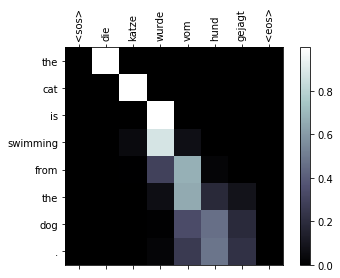

In [ ]:
source = "Die Katze wurde vom Hund gejagt"
target = "the cat was chased by the dog"

translation, attention = translate_sentence(source)
display_attention(source, translation, attention)